In [1]:
# Load libraries
import pandas as pd
import numpy as np
# Graphs
import matplotlib.pyplot as plt
import seaborn as sns
# Time Series
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
# import rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 
# Warnings
import warnings
warnings.filterwarnings("ignore")

## Load Files

In [2]:
# Read csv files
rent = pd.read_csv('data/metro_zillow_rent_mean.csv')
regions = pd.read_csv('data/states.csv')
# Median income for household
# 2020, 2023, 2024 increase of 3%
income = pd.read_csv('data/region_income.csv')
us_income = pd.read_csv('data/us_income.csv')

## Data Preparation

### Rent

In [3]:
#Grab only first row of US mean rent
usrent = rent.iloc[0:1,55:].melt(var_name='date', value_name='rent')

In [4]:
# Combine rent avg and region
rent_region = pd.merge(rent, regions, how='left', left_on=['StateName'], right_on=['State Code'])

In [5]:
# Group rent avg by region
# Fill in empty with mean
rent_region = rent_region.iloc[:,55:].groupby(['Region']).mean().reset_index()

In [6]:
# Limit columns to date and region
# melt to show region>date>rent
rent_melt = rent_region.melt(id_vars="Region", var_name='date', value_name='rent')

### Price Format (Region Only)

In [7]:
# Reformat price to float with 2 decimal points
rent_melt['rent'] = round(rent_melt['rent'].astype(float),2)

### Set Date / Year

In [8]:
usrent['date'] = pd.to_datetime(usrent['date'])
usrent['Year'] = usrent['date'].dt.year.astype(int)

In [9]:
# Convert to date (first of the month)
rent_melt['date'] = pd.to_datetime(rent_melt['date'])
rent_melt['year'] = rent_melt['date'].dt.year.astype(int)

In [10]:
# Float to int
income['year'] = income['Year'].astype(int)
income.drop('Year', axis=1, inplace=True)

### Combine Rent and Income

In [11]:
# Combine us rent and income
usrent_merged = pd.merge(usrent, us_income, how='left')

In [12]:
# combine regent rent and income
rent_melt = pd.merge(rent_melt, income, how='left', on=["year","Region"])

### Rent to Income ratio

In [13]:
# US Ratio 
usrent_merged['month_income'] = round(usrent_merged['US_Income']/12,2)
usrent_merged['ratio'] = (usrent_merged['rent']/usrent_merged['month_income']).astype(float)

In [14]:
# Region Ratio
rent_melt['month_income'] = round(rent_melt['NF_Income']/12,2)
rent_melt['ratio'] = rent_melt['rent']/rent_melt['month_income']

### Split Regions & Set Frequency

In [15]:
# US Date Index
usrent_merged.set_index('date', inplace=True)

In [16]:
usrent_merged = usrent_merged.asfreq('M').iloc[:,4:]

In [17]:
# Midwest
midwest = rent_melt[rent_melt['Region']=="Midwest"]
midwest.drop('Region', axis=1, inplace=True)
midwest.set_index('date', inplace=True)
midwest = midwest.asfreq('M').iloc[:,4:]

In [18]:
# Northeast
northeast = rent_melt[rent_melt['Region']=="Northeast"]
northeast.drop('Region', axis=1, inplace=True)
northeast.set_index('date', inplace=True)
northeast = northeast.asfreq('M').iloc[:,4:]

In [19]:
# South
south = rent_melt[rent_melt['Region']=="South"]
south.drop('Region', axis=1, inplace=True)
south.set_index('date', inplace=True)
south = south.asfreq('M').iloc[:,4:]

In [20]:
# West
west = rent_melt[rent_melt['Region']=="West"]
west.drop('Region', axis=1, inplace=True)
west.set_index('date', inplace=True)
west = west.asfreq('M').iloc[:,4:]

## Exploration

<AxesSubplot:xlabel='rent', ylabel='Count'>

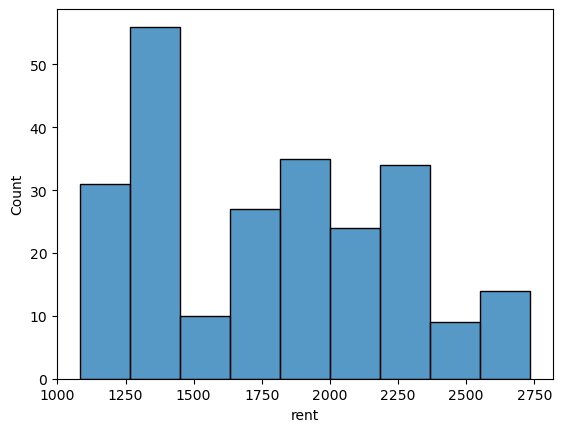

In [21]:
sns.histplot(data=rent_melt, x="rent")

<AxesSubplot:xlabel='NF_Income', ylabel='Count'>

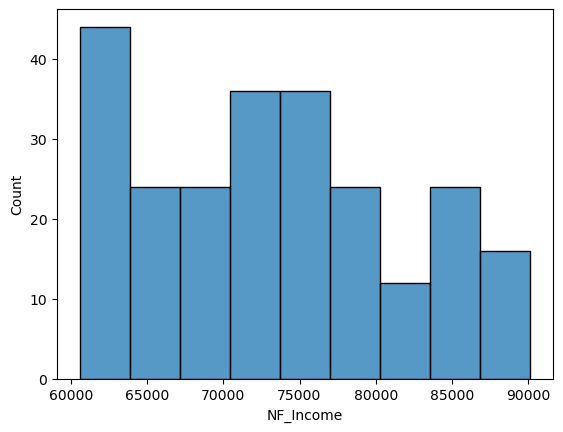

In [22]:
sns.histplot(data=rent_melt, x="NF_Income")

<AxesSubplot:xlabel='date', ylabel='ratio'>

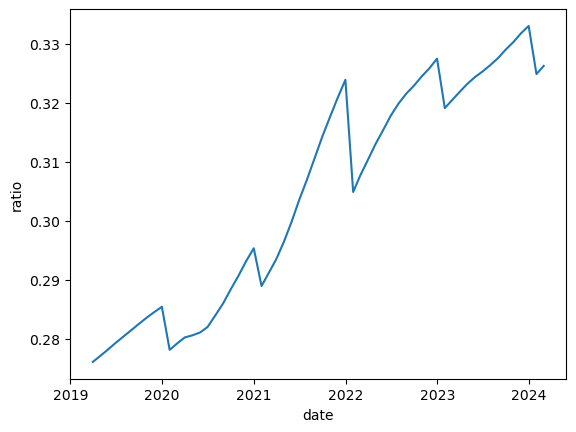

In [23]:
sns.lineplot(data=usrent_merged, x=usrent_merged.index, y="ratio")

In [24]:
usrent_merged.to_csv('usrent.csv')  

<AxesSubplot:xlabel='date', ylabel='ratio'>

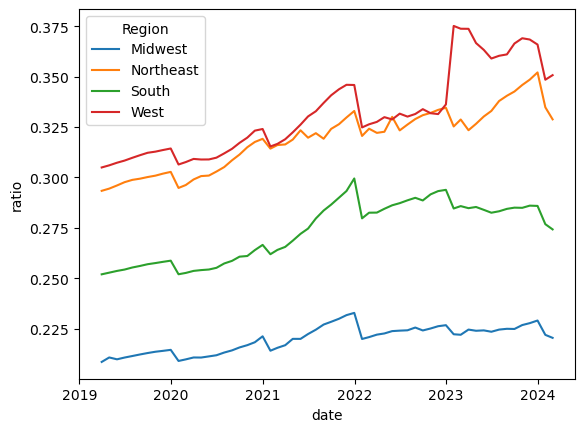

In [25]:
sns.lineplot(data=rent_melt, x="date", y="ratio", hue="Region")

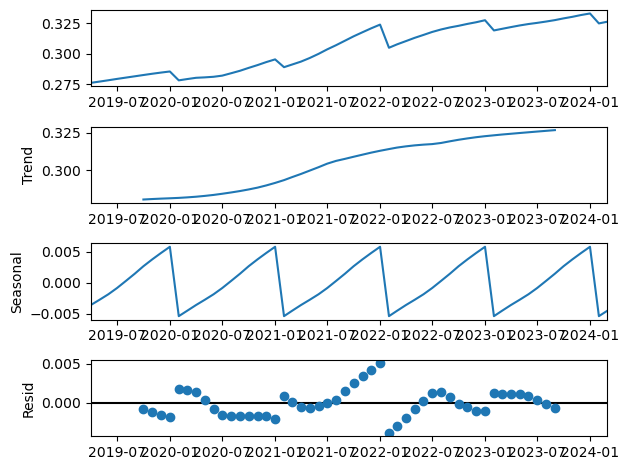

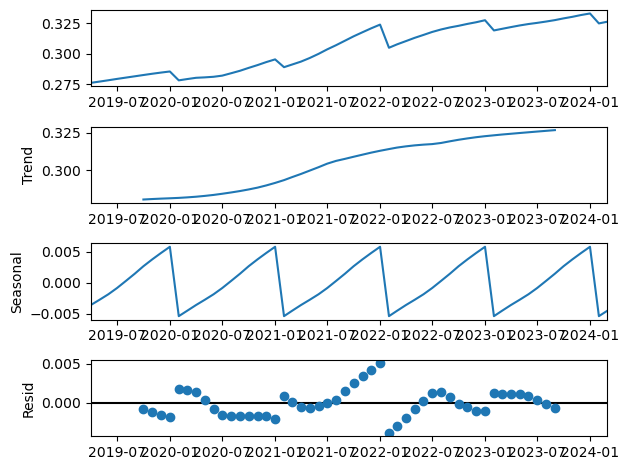

In [26]:
result = seasonal_decompose(usrent_merged, model='additive')
result.plot()

<AxesSubplot:xlabel='rent', ylabel='month_income'>

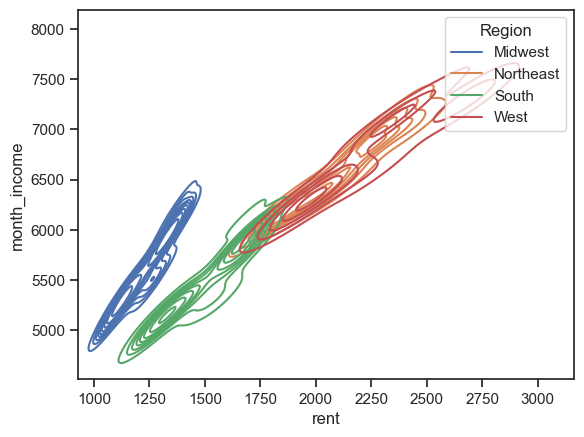

In [27]:
sns.set_theme(style="ticks")
sns.kdeplot(data=rent_melt, x="rent", y="month_income", hue="Region", kind="kde")

In [28]:
rent_melt.to_csv('relationship.csv', index=False)  

## Test/Train & Model Selection

In [29]:
region_lst = [midwest,northeast,south,west]

In [30]:
# Find parametersfor US
train = usrent_merged.loc[:'2023-09']
test = usrent_merged.loc['2023-09':]

In [31]:
#auto_arima(train,start_p=0,d=1,start_q=0,max_p=5,
           #max_d=5,max_q=5,start_P=0,D=1,start_Q=0,
           #max_P=5,max_D=5,max_Q=5,m=12,seasonal=True,
           #error_action='warn',trace=True,supress_warnings=True,
           #stepwise=True,random_state=20,n_fits=100)

0.0043383780774449935


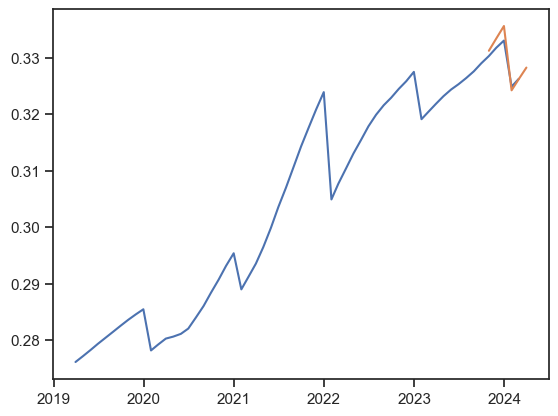

In [32]:
fitted_model = SARIMAX(train['ratio'], order=(1,1,0), seasonal_order=(5, 1, 4, 12)).fit()
plt.plot(usrent_merged)
forecast = fitted_model.forecast(6)  
plt.plot(forecast)
print(sqrt(mean_squared_error(test['ratio'], forecast)))

In [33]:
# Find parameters based off one region
train = south.loc[:'2023-09']
test = south.loc['2023-09':]

In [34]:
auto_arima(train,start_p=0,d=1,start_q=0,max_p=5,
           max_d=5,max_q=5,start_P=0,D=1,start_Q=0,
           max_P=5,max_D=5,max_Q=5,m=12,seasonal=True,
           error_action='warn',trace=True,supress_warnings=True,
           stepwise=True,random_state=20,n_fits=100)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-352.898, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-356.867, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=-365.295, Time=0.19 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=-350.938, Time=0.08 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=-359.978, Time=0.29 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=-361.906, Time=1.01 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=-356.582, Time=0.08 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=-358.096, Time=0.52 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=-350.900, Time=0.10 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=-359.043, Time=0.24 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=-363.385, Time=0.60 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=-364.018, Time=0.41 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=-359.767, Time=0.47 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=-363.545, Time=0.36 sec

Best model:  ARIMA

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

0.003878821369356054
0.007826571011771097
0.005663780666013102
0.015232087264325386


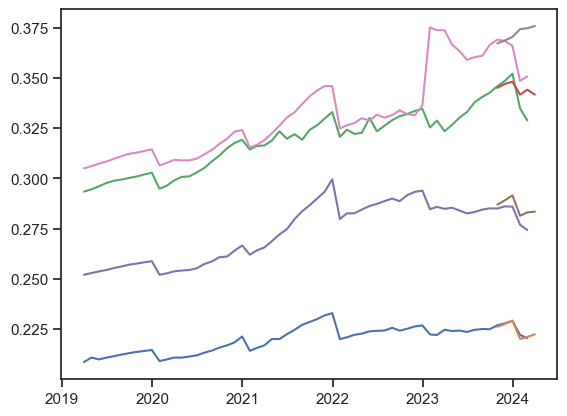

In [35]:
x = 0
# Loop through regions
for region in region_lst:
    
    # Split train/test
    train = region.loc[:'2023-09']
    test = region.loc['2023-09':]
    
    plt.plot(region)
    
    if(x==0):
        # Midwest
        fitted_model = SARIMAX(train, order=(0, 1, 0), seasonal_order=(3, 1, 1, 12)).fit()
    elif(x==1):
        # Northeast
        fitted_model = SARIMAX(train, order=(1, 1, 0), seasonal_order=(2, 1, 0, 12)).fit()
    elif(x==2):
        # South
        fitted_model = SARIMAX(train, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12)).fit()
    else:
        # West
        fitted_model = SARIMAX(train, order=(0, 1, 0), seasonal_order=(0, 1, 1, 12)).fit()
    
    # fitted_model = ExponentialSmoothing(train['ratio'],trend='add',seasonal='add',seasonal_periods=12).fit()
    
    forecast = fitted_model.forecast(6)
    
    plt.plot(forecast)

    print(sqrt(mean_squared_error(test['ratio'], forecast)))
    
    x+=1

## SARIMAX Model

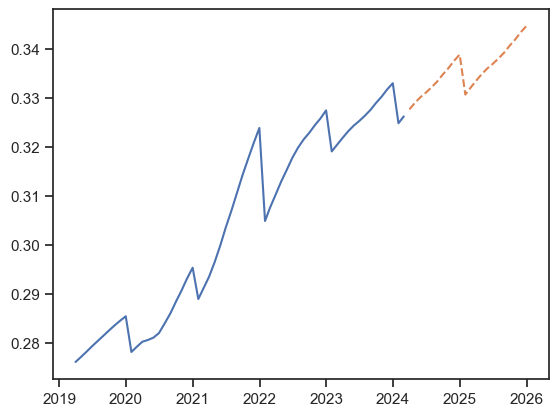

In [36]:
# Create US Model
fitted_model = SARIMAX(usrent_merged, order=(1,1,0), seasonal_order=(0, 1, 1, 12)).fit()
predict = fitted_model.predict(start=60,end=81,dynamic=True)
plt.plot(usrent_merged)
plt.plot(predict, linestyle="dashed")

In [37]:
predict.to_csv('us_predictions.csv')  

In [38]:
usrent_merged.to_csv('us_trend.csv')  

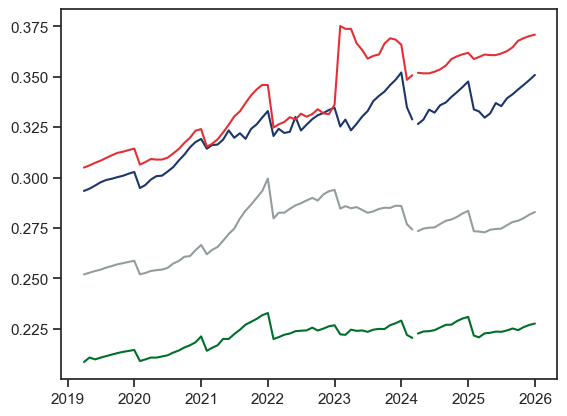

In [39]:
# Create Region Model
x=0
region_name = ['Midwest','Northeast','South','West']
colors = ["#006f2b","#1c366a","#939d9f","#e43034"]
predict_list =  []
# Loop through regions
for region in region_lst:
    if(x==0):
        # Midwest
        fitted_model = SARIMAX(region, order=(0, 1, 0), seasonal_order=(3, 1, 1, 12)).fit()
    elif(x==1):
        # Northeast
        fitted_model = SARIMAX(region, order=(1, 1, 0), seasonal_order=(2, 1, 0, 12)).fit()
    elif(x==2):
        # South
        fitted_model = SARIMAX(region, order=(0, 1, 1), seasonal_order=(0, 1, 1, 12)).fit()
    else:
        # West
        fitted_model = SARIMAX(region, order=(0, 1, 0), seasonal_order=(0, 1, 1, 12)).fit()
    predict = fitted_model.predict(start=60,end=81,dynamic=True)
    plt.plot(predict, color=colors[x], label=region_name[x])
    plt.plot(region, color=colors[x], label=region_name[x])
    predict_list.append(predict)
    x+=1

In [40]:
region_predict = pd.DataFrame(predict_list).melt()

In [41]:
region_predict.to_csv('region_predictions.csv', index=False)  